# Example notebook

In [ ]:
#import thư viện
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import torch
import torch.nn.functional as F
import random
import heapq
from collections import deque
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns


c:\Users\PC\Downloads\Projects\NCKH\PathPlanning\floortrans\loaders\svg_utils.py:565: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direction is 'H':
c:\Users\PC\Downloads\Projects\NCKH\PathPlanning\floortrans\loaders\svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4
c:\Users\PC\Downloads\Projects\NCKH\PathPlanning\floortrans\loaders\svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4


In [ ]:
#Load mô hình
mod_path  = r'C:\Users\PC\Downloads\Projects\NCKH\PathPlanning\model_best_val_loss_var.pkl'

rot = RotateNTurns()
#room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
#icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = r"C:\Users\PC\Downloads\cubicasa5k"
data_file = r'\test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load(mod_path)

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


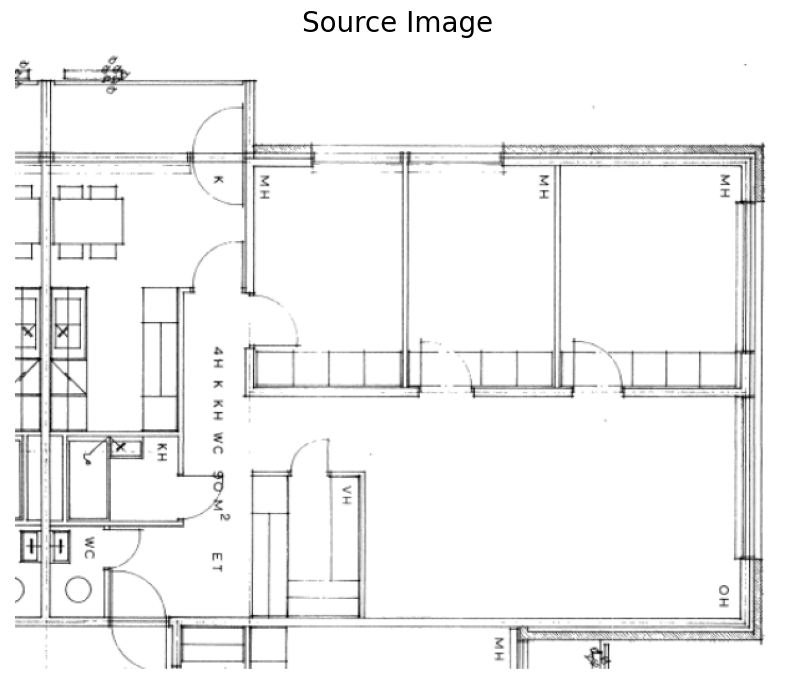

In [ ]:
#Thay đổi dữ liệu ảnh
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
label_np = label.data.numpy()[0]
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

# Create map


In [ ]:
#Tạo prediction
with torch.no_grad():
    height = label_np.shape[1]
    width = label_np.shape[2]
    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

In [ ]:
#Gán nhãn
prediction = torch.mean(prediction, 0, True)
rooms_label = label_np[0]
icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0) #max along columns

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

In [20]:
def filter_classes(rooms_pred, icons_pred):
    """
    Filter rooms_pred and icons_pred to keep only Wall (1), Door (2), Window (3), others as 0.
    Args:
        rooms_pred: numpy array [height, width], predicted room classes (0-11).
        icons_pred: numpy array [height, width], predicted icon classes (0-10).
    Returns:
        filtered_map: numpy array [height, width], with values 0, 1 (Wall), 2 (Door), 3 (Window).
    """
    height, width = rooms_pred.shape
    # Initialize output array with zeros
    filtered_map = np.zeros((height, width), dtype=np.uint8)

    # Room classes: Wall is index 2 in room_classes
    ENTRY_INDEX = 7
    WALL_ROOM_INDEX = 2
    # Icon classes: Window is index 1, Door is index 2 in icon_classes
    WINDOW_ICON_INDEX = 1
    DOOR_ICON_INDEX = 2

    # Assign values based on class indices
    filtered_map[rooms_pred == WALL_ROOM_INDEX] = 1  # Wall
    filtered_map[icons_pred == DOOR_ICON_INDEX] = 2  # Door
    filtered_map[icons_pred == WINDOW_ICON_INDEX] = 3  # Window
    filtered_map[rooms_pred == ENTRY_INDEX] = 4  # Others

    return filtered_map

In [ ]:
#Lọc những nhãn cần dùng
filtered_map = filter_classes(rooms_pred, icons_pred)

In [ ]:
#print("filtered_map shape:", getattr(filtered_map, 'shape', None))
#print("filtered_map unique values:", np.unique(filtered_map) if isinstance(filtered_map, np.ndarray) else filtered_map)

filtered_map shape: (514, 622)
filtered_map unique values: [0 1 2 3 4]


In [ ]:
'''def flood_fill(grid, start_pos):
    rows, cols = len(grid), len(grid[0])
    if grid[start_pos[0]][start_pos[1]] != 0:
        return set(), False  # Không bắt đầu từ ô 0

    visited = set()
    queue = deque([start_pos])
    is_enclosed = True  # Kiểm tra vùng có khép kín hay không

    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)

        # Nếu chạm biên bản đồ, vùng không khép kín
        if current[0] == 0 or current[0] == rows - 1 or current[1] == 0 or current[1] == cols - 1:
            is_enclosed = False

        # Kiểm tra các ô lân cận (lên, phải, xuống, trái)
        for dr, dc in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
            next_pos = (current[0] + dr, current[1] + dc)
            if (0 <= next_pos[0] < rows and 0 <= next_pos[1] < cols and
                next_pos not in visited and grid[next_pos[0]][next_pos[1]] == 0):
                queue.append(next_pos)

    return visited, is_enclosed

# Hàm kiểm tra khu vực 10x10 có hợp lệ không
def is_valid_10x10_area(grid, top_left):
    rows, cols = len(grid), len(grid[0])
    # Kiểm tra xem khu vực 10x10 có nằm trong bản đồ và tất cả ô là 0
    if top_left[0] + 9 >= rows or top_left[1] + 9 >= cols:
        return False
    for i in range(top_left[0], top_left[0] + 10):
        for j in range(top_left[1], top_left[1] + 10):
            if grid[i][j] != 0:
                return False
    return True

# Hàm chọn vị trí ngẫu nhiên 10x10 trong vùng khép kín
def random_person_in_enclosed_area(filtered_map):
    rows, cols = len(filtered_map), len(filtered_map[0])

    # Tìm tất cả các ô 0 (trừ biên để tránh kiểm tra không cần thiết)
    valid_positions = [(i, j) for i in range(1, rows-1) for j in range(1, cols-1) if filtered_map[i][j] == 0]

    # Thử từng ô để tìm vùng khép kín
    for pos in random.sample(valid_positions, len(valid_positions)):  # Xáo trộn để chọn ngẫu nhiên
        region, is_enclosed = flood_fill(filtered_map, pos)
        if is_enclosed and region:  # Nếu vùng khép kín và không rỗng
            # Tìm tất cả các ô top-left của khu vực 10x10 hợp lệ trong vùng khép kín
            valid_10x10_positions = [
                (i, j) for i, j in region
                if is_valid_10x10_area(filtered_map, (i, j))
            ]
            if valid_10x10_positions:
                # Chọn ngẫu nhiên một ô top-left cho khu vực 10x10
                top_left = random.choice(valid_10x10_positions)
                # Đánh dấu khu vực 10x10 bằng giá trị 6
                for i in range(top_left[0], top_left[0] + 10):
                    for j in range(top_left[1], top_left[1] + 10):
                        filtered_map[i][j] = 6  # Đánh dấu khu vực người
                return top_left  # Trả về ô top-left làm vị trí đại diện

    return None  # Không tìm thấy vùng khép kín chứa khu vực 10x10

def mark_path_on_map(filtered_map, path):
    if path:
        for pos in path:
            if filtered_map[pos[0]][pos[1]] != 6:  # Không ghi đè khu vực người
                filtered_map[pos[0]][pos[1]] = 5  # Đánh dấu đường đi
    return filtered_map'''

In [29]:
def create_discrete_cmap():
    colors = ['white', 'black', 'green', 'blue', 'yellow', 'red','darkgreen','darkblue']
    cmap = ListedColormap(colors)
    return cmap

new_cmap = create_discrete_cmap()

In [27]:
classes = ['Background', 'Wall', 'Door', 'Window', 'Entry', 'Path', 'User', 'Goal']

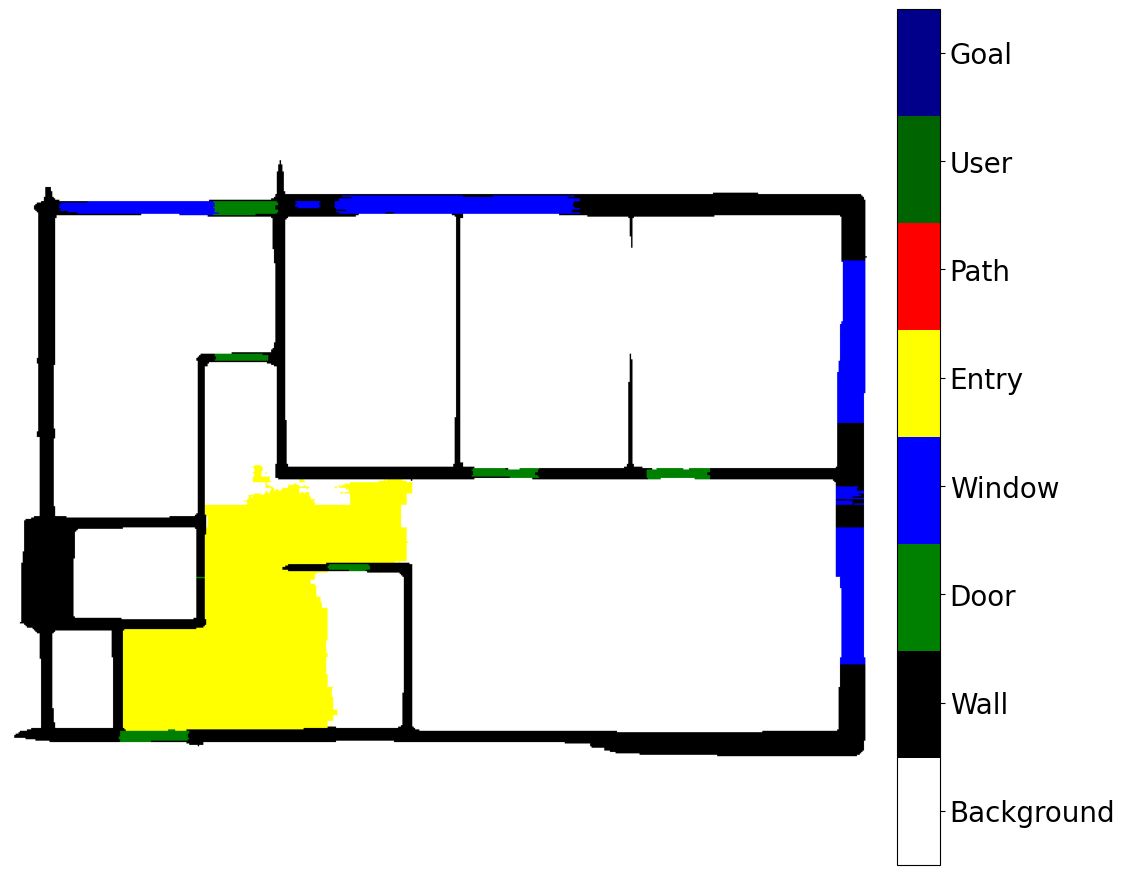

In [ ]:
#Hiện thị ảnh đã lọc
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
# Use the new colormap and set appropriate vmin and vmax based on the number of classes (0 to 4)
rseg = ax.imshow(filtered_map, cmap=new_cmap, vmin=0, vmax=len(classes)-0.1)
# Update the colorbar ticks and labels to reflect the new classes
cbar = plt.colorbar(rseg, ticks=np.arange(len(classes))+0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(classes, fontsize=20)
plt.show()

In [31]:
def repair_walls(grid, max_gap=2):
    """
    Hàm sửa chữa tường trong grid 2D bằng cách lấp đầy khe hở nhỏ theo row và column.
    Lấp cả khi ở giữa là background (0) hoặc entry (4).
    """
    if not isinstance(grid, np.ndarray):
        grid = np.array(grid)

    rows, cols = grid.shape
    repaired_grid = grid.copy()  # Sao chép để tránh thay đổi grid gốc

    # Hàm phụ để lấp gap trong một mảng 1D (row hoặc column)
    def fill_gaps(line):
        i = 0
        while i < len(line):
            if line[i] == 1:
                # Tìm đoạn tường bắt đầu
                start = i
                while i < len(line) and line[i] == 1:
                    i += 1
                end = i

                # Kiểm tra gap sau đoạn tường này
                gap_start = i
                while i < len(line) and line[i] in (0, 4):  # Sửa ở đây: chấp nhận cả background và entry
                    i += 1
                gap_end = i

                gap_size = gap_end - gap_start
                if 0 < gap_size <= max_gap and gap_end < len(line) and line[gap_end] == 1:
                    # Lấp gap nhỏ nếu phía sau là tường
                    line[gap_start:gap_end] = 1
                i = end  # Quay lại để tiếp tục từ end của đoạn tường
            else:
                i += 1

    # Sửa theo row
    for r in range(rows):
        row_line = repaired_grid[r, :]
        fill_gaps(row_line)

    # Sửa theo column (transpose để dễ xử lý như row)
    transposed = repaired_grid.T
    for c in range(cols):
        col_line = transposed[c, :]
        fill_gaps(col_line)
    repaired_grid = transposed.T  # Chuyển lại về grid gốc

    return repaired_grid


In [32]:
def propagate_door_window_cross(filtered_map, gap=8):
    """
    Lan truyền cửa/cửa sổ theo chiều vuông góc với đoạn cửa/cửa sổ liên tiếp,
    với chiều dài tối đa bằng chiều dài đoạn cửa/cửa sổ ban đầu.
    Nếu không kết nối được 2 background (0) ở hai đầu, sẽ tìm background gần nhất cách đoạn cửa/cửa sổ tối đa gap pixel.
    """
    result = filtered_map.copy()
    rows, cols = filtered_map.shape
    visited = np.zeros_like(filtered_map, dtype=bool)

    # Xử lý các đoạn dọc (cửa/cửa sổ đứng)
    for j in range(cols):
        i = 0
        while i < rows:
            if filtered_map[i, j] in (2, 3) and not visited[i, j]:
                val = filtered_map[i, j]
                # Tìm đoạn liên tiếp theo chiều dọc
                start = i
                while i < rows and filtered_map[i, j] == val:
                    visited[i, j] = True
                    i += 1
                end = i
                length = end - start
                if length > 0:
                    for k in range(start, end):
                        # Lan truyền sang trái
                        left = j - 1
                        count = 0
                        found_bg = False
                        while left >= 0 and count < length and result[k, left] == 1:
                            result[k, left] = val
                            left -= 1
                            count += 1
                        if left >= 0 and result[k, left] == 0:
                            found_bg = True
                        # Nếu không tìm thấy background, tìm background gần nhất trong phạm vi gap
                        if not found_bg:
                            for d in range(1, gap+1):
                                idx = j - d
                                if idx >= 0 and result[k, idx] == 0:
                                    for fill in range(j-1, idx, -1):
                                        if result[k, fill] == 1:
                                            result[k, fill] = val
                                    break
                        # Lan truyền sang phải
                        right = j + 1
                        count = 0
                        found_bg = False
                        while right < cols and count < length and result[k, right] == 1:
                            result[k, right] = val
                            right += 1
                            count += 1
                        if right < cols and result[k, right] == 0:
                            found_bg = True
                        if not found_bg:
                            for d in range(1, gap+1):
                                idx = j + d
                                if idx < cols and result[k, idx] == 0:
                                    for fill in range(j+1, idx):
                                        if result[k, fill] == 1:
                                            result[k, fill] = val
                                    break
            else:
                i += 1

    # Xử lý các đoạn ngang (cửa/cửa sổ nằm ngang)
    for i in range(rows):
        j = 0
        while j < cols:
            if filtered_map[i, j] in (2, 3) and not visited[i, j]:
                val = filtered_map[i, j]
                # Tìm đoạn liên tiếp theo chiều ngang
                start = j
                while j < cols and filtered_map[i, j] == val:
                    visited[i, j] = True
                    j += 1
                end = j
                length = end - start
                if length > 0:
                    for k in range(start, end):
                        # Lan truyền lên trên
                        up = i - 1
                        count = 0
                        found_bg = False
                        while up >= 0 and count < length and result[up, k] == 1:
                            result[up, k] = val
                            up -= 1
                            count += 1
                        if up >= 0 and result[up, k] == 0:
                            found_bg = True
                        if not found_bg:
                            for d in range(1, gap+1):
                                idx = i - d
                                if idx >= 0 and result[idx, k] == 0:
                                    for fill in range(i-1, idx, -1):
                                        if result[fill, k] == 1:
                                            result[fill, k] = val
                                    break
                        # Lan truyền xuống dưới
                        down = i + 1
                        count = 0
                        found_bg = False
                        while down < rows and count < length and result[down, k] == 1:
                            result[down, k] = val
                            down += 1
                            count += 1
                        if down < rows and result[down, k] == 0:
                            found_bg = True
                        if not found_bg:
                            for d in range(1, gap+1):
                                idx = i + d
                                if idx < rows and result[idx, k] == 0:
                                    for fill in range(i+1, idx):
                                        if result[fill, k] == 1:
                                            result[fill, k] = val
                                    break
            else:
                j += 1
    return result

In [ ]:
#Sửa tường
filtered_map = repair_walls(filtered_map, max_gap=40)

In [ ]:
#Kết nối cửa/cửa sổ với background
filtered_map = propagate_door_window_cross(filtered_map)

# Path

In [ ]:
#Sử dụng A* algorithm
'''

# Định nghĩa lớp Node để lưu thông tin ô trong lưới
class Node:
    def __init__(self, position, g=0, h=0, parent=None):
        self.position = position  # Tọa độ (row, col)
        self.g = g  # Chi phí từ điểm xuất phát đến node hiện tại
        self.h = h  # Heuristic: Ước lượng chi phí đến đích
        self.f = g + h  # Tổng chi phí (f = g + h)
        self.parent = parent  # Node cha để truy vết đường đi

    def __lt__(self, other):
        return self.f < other.f

# Hàm heuristic: Khoảng cách Manhattan
def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Hàm đánh dấu đường đi trên bản đồ
def mark_path_on_map(filtered_map, path):
    if path:
        for pos in path:
            filtered_map[pos[0]][pos[1]] = 5  # Đánh dấu đường đi với giá trị 5
    return filtered_map

def reset_person_area(filtered_map):
    rows, cols = len(filtered_map), len(filtered_map[0])
    for i in range(rows):
        for j in range(cols):
            if filtered_map[i][j] == 6:  # Khu vực người cũ
                filtered_map[i][j] = 0  # Đặt lại thành ô trống
    return filtered_map
# Thuật toán A*
def a_star(grid, start, goal):
    rows, cols = len(grid), len(grid[0])

    # Kiểm tra tính hợp lệ của start và goal
    if grid[start[0]][start[1]] == 1 or grid[goal[0]][goal[1]] == 1:
        return None  # Điểm bắt đầu hoặc đích là chướng ngại vật

    # Danh sách mở (open list) sử dụng hàng đợi ưu tiên
    open_list = []
    heapq.heappush(open_list, Node(start, 0, manhattan_distance(start, goal)))

    # Danh sách đóng (closed list) để lưu các node đã duyệt
    closed_set = set()

    # Các hướng di chuyển (lên, phải, xuống, trái)
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    while open_list:
        # Lấy node có f nhỏ nhất từ open list
        current_node = heapq.heappop(open_list)
        current_pos = current_node.position

        # Nếu đến đích, truy vết đường đi
        if current_pos == goal:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # Đảo ngược để có đường đi từ start đến goal

        # Thêm node hiện tại vào closed set
        closed_set.add(current_pos)

        # Kiểm tra các node lân cận
        for direction in directions:
            next_pos = (current_pos[0] + direction[0], current_pos[1] + direction[1])

            # Kiểm tra tính hợp lệ của vị trí mới
            if (0 <= next_pos[0] < rows and 0 <= next_pos[1] < cols and
                next_pos not in closed_set and grid[next_pos[0]][next_pos[1]] == 0):

                # Tính chi phí g và h mới
                new_g = current_node.g + 1  # Chi phí di chuyển sang ô lân cận
                new_h = manhattan_distance(next_pos, goal)

                # Kiểm tra xem node đã có trong open list chưa
                new_node = Node(next_pos, new_g, new_h, current_node)
                if not any(node.position == next_pos and node.f <= new_node.f for node in open_list):
                    heapq.heappush(open_list, new_node)

    return None  # Không tìm thấy đường đi

# Ví dụ sử dụng
def main(filtered_map):
    grid = filtered_map

    start = random_person_in_enclosed_area(filtered_map)
    if start is None:
        print("Không tìm thấy vùng khép kín hợp lệ cho người!")
        return

    goal = random_person_in_enclosed_area(filtered_map)
        # Xóa khu vực người cũ
    filtered_map = reset_person_area(filtered_map)

        # Chọn ngẫu nhiên khu vực 10x10 cho người trong vùng khép kín
    start = random_person_in_enclosed_area(filtered_map)
    if start is None:
        print("Không tìm thấy vùng khép kín chứa khu vực 10x10 hợp lệ cho người!")

    print(f"\nKhu vực người mới (top-left): {start}")

        # Tìm đường đi với A*
    path = a_star(filtered_map, start, goal)

    if path:
        print("Đường đi tìm được:", path)
            # Đánh dấu đường đi trên bản đồ
        filtered_map = mark_path_on_map(filtered_map, path)
    else:
        print("Không tìm thấy đường đi.")

if __name__ == "__main__":
    main(filtered_map)'''

KeyboardInterrupt: 